## Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import keras.backend as K

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from lr_utils.keras_LRFinder import LRFinder
from lr_utils.keras_SGDR import SGDR
from lr_utils.keras_CLR import CyclicLR, CLR

/home/knataraj/.conda/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load the dataset

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [4]:
num_classes = 10
batch_size = 128
epochs=5

In [5]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Create a Network

The loss function has to be **categorical_crossentropy** since we deal with categorical labels.
The same goes for the last activation which has to be **softmax** since we have more than two classes (sigmoid would be fine for two classes).

In [6]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


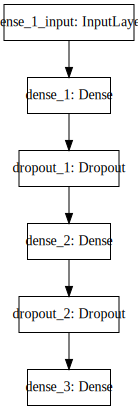

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Find the optimal Learning Rate

This method has been proposed by Leslie Smith. The concept to find the best learning rate is to begin at a small one, and increase it progressively. By looking at the loss function for the values of the Learning Rate, we can see it being very stable (no improvement) when the LR is small, then drop faster and faster and finally oscillate and diverge when the LR is too big. The optimal LR stands in the middle, where the slope is the steepest (not at the minimum of the curve).

In [8]:
lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-2, step_size=np.ceil(X_train.shape[0]/batch_size))
model.fit(X_train, y_train, callbacks=[lr_finder] )

Epoch 1/1
25056/60000 [===========>..................] - ETA: 8s - loss: 1.9261 - acc: 0.3615

Raw loss values

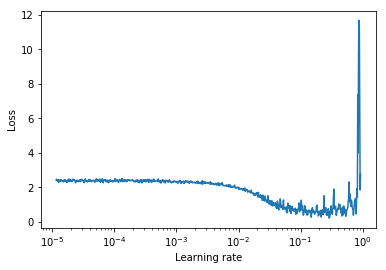

In [9]:
lr_finder.plot_loss()

Smoothed loss values. It is now easier to find the optimal learning rate

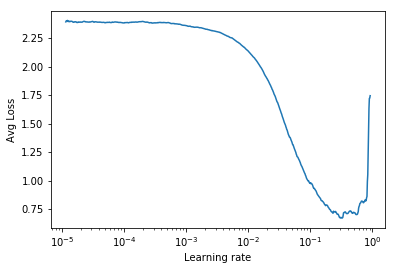

In [10]:
lr_finder.plot_avg_loss()

The optimal learning rate is in the part of the graph where the slope is the steepest, here between 2e-2 and 1e-1. We want to take the highest learning rate without taking too much risks (close from the minimum). A good value seems to be 7e-2.

## Cyclical Learning Rate and Momentum

In [11]:
clr = CLR(min_lr=7e-3, max_lr=7e-2, min_mtm = 0.85, max_mtm = 0.95, annealing=0.1, step_size=np.ceil(((X_train.shape[0]*epochs)/(batch_size))))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.4707 - acc: 0.8795 - val_loss: 0.1556 - val_acc: 0.9519
Epoch 2/5
60000/60000 [==============================] - 6s 103us/step - loss: 0.1636 - acc: 0.9509 - val_loss: 0.1081 - val_acc: 0.9660
Epoch 3/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.1174 - acc: 0.9645 - val_loss: 0.0839 - val_acc: 0.9719
Epoch 4/5
60000/60000 [==============================] - 7s 113us/step - loss: 0.0909 - acc: 0.9712 - val_loss: 0.0680 - val_acc: 0.9794
Epoch 5/5
60000/60000 [==============================] - 7s 114us/step - loss: 0.0660 - acc: 0.9794 - val_loss: 0.0619 - val_acc: 0.9807


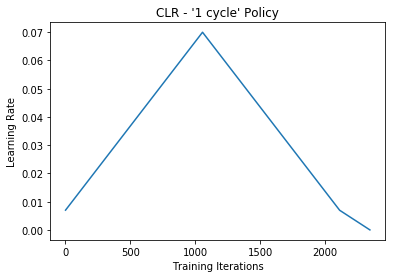

In [13]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - '1 cycle' Policy")
plt.plot(clr.history['iterations'], clr.history['lr'])

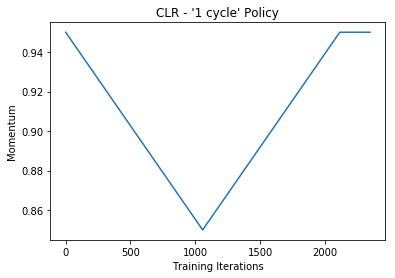

In [14]:
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("CLR - '1 cycle' Policy")
plt.plot(clr.history['iterations'], clr.history['momentum'])

## Stochastic Gradient Descent with Restart (SGDR)

In [15]:
sgdr = SGDR(min_lr=7e-3,max_lr=7e-2,step_size=np.ceil(X_train.shape[0]/batch_size), lr_decay=0.9, mult_factor=1.5)
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[sgdr])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.0549 - acc: 0.9834 - val_loss: 0.0617 - val_acc: 0.9811
Epoch 2/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.0536 - acc: 0.9835 - val_loss: 0.0601 - val_acc: 0.9813
Epoch 3/5
60000/60000 [==============================] - 6s 96us/step - loss: 0.0495 - acc: 0.9854 - val_loss: 0.0593 - val_acc: 0.9819
Epoch 4/5
60000/60000 [==============================] - 6s 96us/step - loss: 0.0510 - acc: 0.9841 - val_loss: 0.0593 - val_acc: 0.9820
Epoch 5/5
60000/60000 [==============================] - 6s 96us/step - loss: 0.0481 - acc: 0.9848 - val_loss: 0.0587 - val_acc: 0.9822


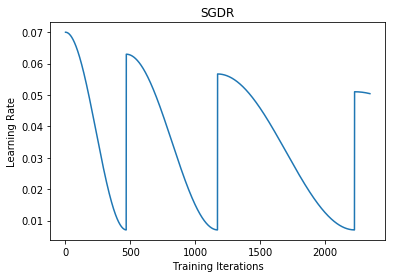

In [17]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("SGDR")
plt.plot(sgdr.history['iterations'], sgdr.history['lr'])

## Cyclical Learning Rate (CLR)

In [18]:
clr_triangular = CyclicLR(mode='triangular', step_size=np.ceil((X_train.shape[0]/batch_size)))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.1928 - acc: 0.9461 - val_loss: 0.2126 - val_acc: 0.9379
Epoch 2/5
60000/60000 [==============================] - 9s 143us/step - loss: 0.1773 - acc: 0.9501 - val_loss: 0.0833 - val_acc: 0.9760
Epoch 3/5
60000/60000 [==============================] - 8s 133us/step - loss: 0.1447 - acc: 0.9609 - val_loss: 0.1883 - val_acc: 0.9512
Epoch 4/5
60000/60000 [==============================] - 8s 140us/step - loss: 0.1989 - acc: 0.9489 - val_loss: 0.0887 - val_acc: 0.9764
Epoch 5/5
60000/60000 [==============================] - 9s 143us/step - loss: 0.1346 - acc: 0.9639 - val_loss: 0.1705 - val_acc: 0.9550


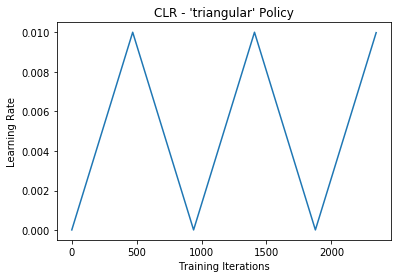

In [20]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [21]:
clr_triangular = CyclicLR(mode='triangular2', step_size=np.ceil(X_train.shape[0]/batch_size))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data= (X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 139us/step - loss: 0.1749 - acc: 0.9569 - val_loss: 0.2033 - val_acc: 0.9523
Epoch 2/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.1823 - acc: 0.9568 - val_loss: 0.0933 - val_acc: 0.9761
Epoch 3/5
60000/60000 [==============================] - 9s 142us/step - loss: 0.1042 - acc: 0.9722 - val_loss: 0.0915 - val_acc: 0.9731
Epoch 4/5
60000/60000 [==============================] - 8s 134us/step - loss: 0.0993 - acc: 0.9733 - val_loss: 0.0783 - val_acc: 0.9797
Epoch 5/5
60000/60000 [==============================] - 8s 137us/step - loss: 0.0679 - acc: 0.9809 - val_loss: 0.0847 - val_acc: 0.9788


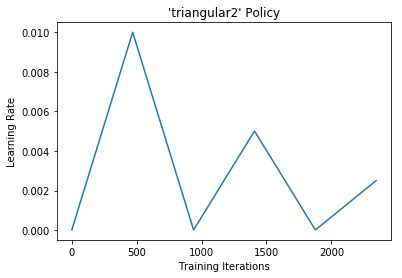

In [23]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [24]:
clr_triangular._reset()

In [25]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=5, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 137us/step - loss: 0.1299 - acc: 0.9673 - val_loss: 0.2105 - val_acc: 0.9528
Epoch 2/5
60000/60000 [==============================] - 8s 129us/step - loss: 0.2382 - acc: 0.9486 - val_loss: 0.1134 - val_acc: 0.9748
Epoch 3/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.1194 - acc: 0.9706 - val_loss: 0.1090 - val_acc: 0.9733
Epoch 4/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.1025 - acc: 0.9732 - val_loss: 0.0961 - val_acc: 0.9770
Epoch 5/5
60000/60000 [==============================] - 8s 131us/step - loss: 0.0745 - acc: 0.9795 - val_loss: 0.0986 - val_acc: 0.9778


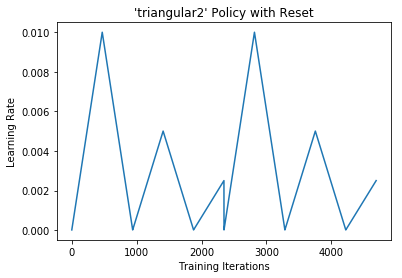

In [26]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy with Reset")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [27]:
clr_triangular = CyclicLR(mode='exp_range', step_size=np.ceil(X_train.shape[0]/batch_size), gamma=0.9994)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 140us/step - loss: 0.1146 - acc: 0.9717 - val_loss: 0.1382 - val_acc: 0.9718
Epoch 2/5
60000/60000 [==============================] - 8s 133us/step - loss: 0.1339 - acc: 0.9696 - val_loss: 0.0935 - val_acc: 0.9782
Epoch 3/5
60000/60000 [==============================] - 8s 131us/step - loss: 0.0877 - acc: 0.9778 - val_loss: 0.1051 - val_acc: 0.9758
Epoch 4/5
60000/60000 [==============================] - 8s 135us/step - loss: 0.0789 - acc: 0.9798 - val_loss: 0.0858 - val_acc: 0.9796
Epoch 5/5
60000/60000 [==============================] - 8s 129us/step - loss: 0.0613 - acc: 0.9834 - val_loss: 0.0955 - val_acc: 0.9789


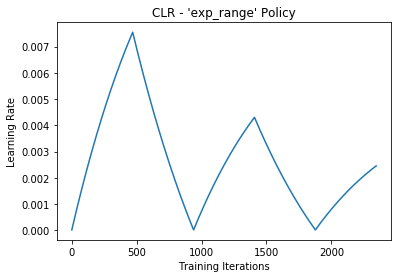

In [29]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'exp_range' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [30]:
clr_triangular._reset(new_base_lr=0.003, new_step_size=np.ceil(X_train.shape[0]/batch_size), new_max_lr=0.009)

In [31]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 129us/step - loss: 0.1322 - acc: 0.9692 - val_loss: 0.2050 - val_acc: 0.9605
Epoch 2/5
60000/60000 [==============================] - 8s 128us/step - loss: 0.1497 - acc: 0.9660 - val_loss: 0.1083 - val_acc: 0.9770
Epoch 3/5
60000/60000 [==============================] - 8s 133us/step - loss: 0.0955 - acc: 0.9761 - val_loss: 0.1147 - val_acc: 0.9745
Epoch 4/5
60000/60000 [==============================] - 8s 139us/step - loss: 0.0982 - acc: 0.9762 - val_loss: 0.1034 - val_acc: 0.9773
Epoch 5/5
60000/60000 [==============================] - 8s 132us/step - loss: 0.0817 - acc: 0.9795 - val_loss: 0.0950 - val_acc: 0.9785


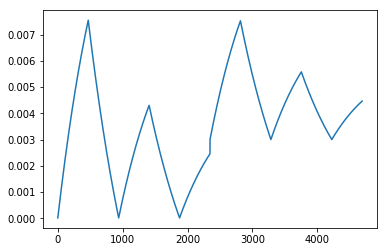

In [32]:
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [33]:
clr = lambda x: 0.5*(1+np.sin(x*np.pi/2.))

In [34]:
clr_triangular = CyclicLR(scale_fn=clr, scale_mode='cycle', step_size=np.ceil(X_train.shape[0]/batch_size))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 135us/step - loss: 0.1194 - acc: 0.9745 - val_loss: 0.2118 - val_acc: 0.9624
Epoch 2/5
60000/60000 [==============================] - 8s 133us/step - loss: 0.1911 - acc: 0.9628 - val_loss: 0.1149 - val_acc: 0.9765
Epoch 3/5
60000/60000 [==============================] - 9s 143us/step - loss: 0.0968 - acc: 0.9775 - val_loss: 0.1194 - val_acc: 0.9772
Epoch 4/5
60000/60000 [==============================] - 8s 135us/step - loss: 0.0892 - acc: 0.9794 - val_loss: 0.1050 - val_acc: 0.9788
Epoch 5/5
60000/60000 [==============================] - 9s 152us/step - loss: 0.0711 - acc: 0.9834 - val_loss: 0.1049 - val_acc: 0.9787


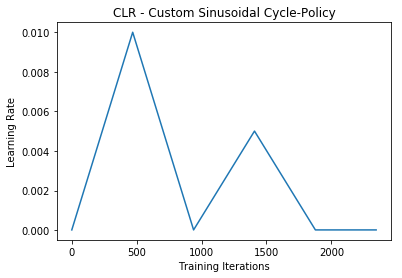

In [36]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Sinusoidal Cycle-Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [37]:
clr = lambda x: 1/(5**(x*0.0001))

In [38]:
clr_triangular = CyclicLR(scale_fn=clr, scale_mode='iterations', step_size=np.ceil(X_train.shape[0]/batch_size))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 153us/step - loss: 0.1210 - acc: 0.9762 - val_loss: 0.2212 - val_acc: 0.9671
Epoch 2/5
60000/60000 [==============================] - 9s 145us/step - loss: 0.1593 - acc: 0.9686 - val_loss: 0.1152 - val_acc: 0.9776
Epoch 3/5
60000/60000 [==============================] - 9s 148us/step - loss: 0.1170 - acc: 0.9752 - val_loss: 0.1693 - val_acc: 0.9730
Epoch 4/5
60000/60000 [==============================] - 9s 145us/step - loss: 0.1529 - acc: 0.9694 - val_loss: 0.1121 - val_acc: 0.9776
Epoch 5/5
60000/60000 [==============================] - 9s 149us/step - loss: 0.1011 - acc: 0.9769 - val_loss: 0.1493 - val_acc: 0.9712


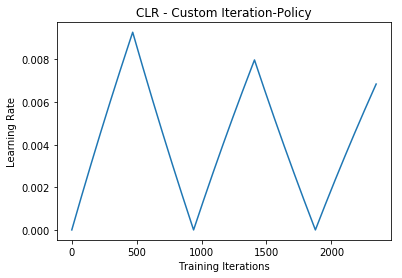

In [40]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Iteration-Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])